## Learning to read emotions in faces using a Semi-Supervised Variational Autoencoder

In the previous VAE example, we learnt how to generate faces in an unsupervised manner after being trained on a set of faces. Great! But the model hasn't learnt anything about emotion in those faces. 

In this example, we use a semi-supervised variant of the VAE to train the model with emotion ratings as well.

This example is adapted from the Pyro [SSVAE Tutorial](http://pyro.ai/examples/ss-vae.html)

We consider the following graphical model:

<div style="width: 300px; margin: auto; ">![Graphical Model](images/graphicalModel_SSVAE.png)
</div>

The difference from the normal VAE is that now there is an additional observed **Emotion Ratings**. The parameters $\theta$ now parameterize the transformation from **ratings** and $z$ to **Facial Expressions** $p_{\theta}(\text{face }| \text{ rating}, z)$.

One way to think about this model, coming from the VAE, is that the addition of the emotion ratings will encourage the model to learn $\theta$ that reflect variance in the face due to emotion.

Another way to think about this model, if we start with just Ratings and Facial Expression, there are many aspects of the face that are not determined by the emotion, such as face shape, gender, and race. Adding $z$ (alongside the emotion ratings) should help to capture these non-emotional features of the face. 

This model is a **semi-supervised variant of the VAE**, or SSVAE (Kingma et al, 2014; Siddharth et al, 2017).
We discuss the SSVAE formulation at a high level, below, and we invite the interested reader to check the reference list at the bottom for the more theoretical details of inference in the SSVAE.) 

We will be using the same Dataset as before: we have a set of (Face, Rating) paired observations (with ~18 unique faces) and a set of 203 unlablled Faces we used for the VAE. 

### Semi-supervised VAE

The model is similar to the VAE in that there are `encoders` and `decoders`. The main difference is that, in addition to the `decoder`, there are now 2 `encoders`:

- `decoder` "goes from" the (latent $z$ and ratings) to the face, i.e. $p_\theta(\text{face }|z, \text{ratings})$)
- `encoder_y` "goes from" the image to the ratings, i.e., $q(\text{ratings } | \text{ face})$
- `encoder_z` "goes from" the (image and ratings) to the latent $z$, i.e., $q(z, | \text{ ratings, face})$

In our SSVAE model, we have a ``.model()`` and ``.guide()`` that are similar to the VAE: they define the reconstruction loss that the model is trained against (Kingma & Welling, 2014). 

We add an additional ``.model_rating()`` and ``.guide_rating()`` to add a "supervised" loss to guide the model to learn from the supervised examples (Kingma et al, 2014).

```
class SemiSupervisedVAE():
    def model(self, emotion, image):
        # condition on the observed data
        emo = pyro.sample("emo", Normal(emo_prior_loc, emo_prior_scale), obs=emotion)
        # sample z given priors
        z = pyro.sample("z", dist.Normal(prior_location, prior_scale))
        # generate the face using emotion and z, and condition on observed image
        loc = self.decoder(torch.cat((z, emo), 1))           
        pyro.sample("face", dist.Bernoulli(loc), obs=image)
        
    def model_rating(self, image, emotion=None):
        # Extra term to yield an auxiliary loss that we do gradient descent on
        if emotion is not None:
            emo_mean, emo_scale = self.encoder_y(image)
            pyro.sample("emo_aux", dist.Normal(emo_mean, emo_scale), obs=emotion)

```

##### Preamble

This first chunk of code imports the necessary python packages and functions that we will use

In [1]:
#from __future__ import division, print_function, absolute_import
from __future__ import print_function

%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam


from torchvision import transforms, utils, datasets
from torchvision.transforms import ToPILImage
from skimage import io, transform
from scipy.special import expit
from PIL import Image
from matplotlib.pyplot import imshow

from pyro.contrib.examples.util import print_and_log, set_seed
import pyro.poutine as poutine
# custom helperCode for this tutorial, in helperCode.py
import helperCode
from utils.custom_mlp import MLP, Exp


from visdom import Visdom

#from utils.vae_plots import plot_llk, plot_vae_samples
from utils.mnist_cached import  mkdir_p, setup_data_loaders
from utils.vae_plots import plot_conditional_samples_ssvae, plot_vae_samples

IMG_WIDTH = 100
IMG_SIZE = IMG_WIDTH*IMG_WIDTH*3
BATCH_SIZE = 32
DEFAULT_HIDDEN_DIMS = [200,200] #[500, 500]
DEFAULT_Z_DIM = 10#50#2

#### Dataset

We will be using the same dataset as the previous examples. We will consider the trials in which participants only saw a facial expression, and rated how they thought the character feels, or what we call the "facial expression only" trials.

Here is a preview of the 18 faces (which are in ../CognitionData/faces/).

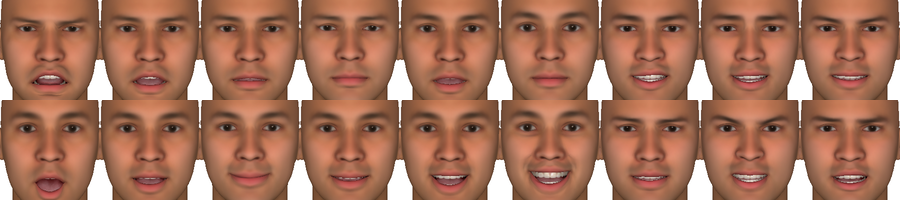

In [2]:
faces_path = os.path.join(os.path.abspath('..'), "CognitionData", "faces")

# initializing two temp arrays
faceArray1 = np.zeros(shape=(100,1,3), dtype='uint8')
faceArray2 = np.zeros(shape=(100,1,3), dtype='uint8')

count = 0
for thisFace in helperCode.FACE_FILENAMES:
    newFaceArray = np.array(Image.open(os.path.join(faces_path, thisFace + ".png")))
    if count < 6 or count > 14:
        faceArray1 = np.concatenate((faceArray1, newFaceArray), axis=1)
    else:
        faceArray2 = np.concatenate((faceArray2, newFaceArray), axis=1)
    count += 1

# concatenating the arrays and removing the first temp column
faceArray = np.concatenate((faceArray1, faceArray2), axis=0)
faceArray = faceArray[:,1:,:]
Image.fromarray(faceArray)

This next chunk defines a function to read in the data, and stores the data in `face_emotion_dataset`. There are N=1,522 observations, and each observation consists of a 8-dimensional emotion rating vector and an accompanying face image.

Reading in dataset...
Number of observations: 1522
Sample Observation: 
['happy', 'sad', 'anger', 'surprise', 'disgust', 'fear', 'content', 'disapp']
[0.75  0.    0.25  0.5   0.25  0.125 0.75  0.25 ]


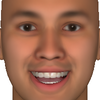

In [3]:
# data location
dataset_path = os.path.join(os.path.abspath('..'), "CognitionData", "data_faceOnly.csv")

class FaceEmotionDataset(Dataset):
    """Face Emotion dataset."""
    
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the experiment csv file 
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.expdata = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.expdata)

    def __getitem__(self, idx):
        emotions = np.array(self.expdata.iloc[idx]["happy":"disapp"], np.float32)
        emotions = (emotions-1)/8
        
        img_name = os.path.join(self.img_dir, self.expdata.iloc[idx]["facePath"] + ".png")
        try:
            image = Image.open(img_name).convert('RGB')
            image = np.array(image).astype(np.float32)

            if self.transform:
                image = self.transform(image)
        except:
            print(img_name)
            raise

        return image, emotions

data_transform = transforms.Compose([
    transforms.ToTensor()
    ])

# reads in datafile.
print("Reading in dataset...")

face_emotion_dataset = FaceEmotionDataset(csv_file=dataset_path, 
                                          img_dir=faces_path, 
                                          transform=data_transform)
face_emotion_loader = torch.utils.data.DataLoader(face_emotion_dataset,
                                                  batch_size=BATCH_SIZE, shuffle=True,
                                                  num_workers=4)

N_samples = len(face_emotion_dataset)
print("Number of observations:", N_samples)

# taking a sample observation
img1, emo1 = face_emotion_dataset[20]
print("Sample Observation: ")
print(helperCode.EMOTION_VAR_NAMES)
print(emo1)
Image.fromarray(helperCode.TensorToPILImage(img1))


#### Additional, unlabelled faces

Here are the additional, unlabelled faces that we had seen in the previous VAE example.

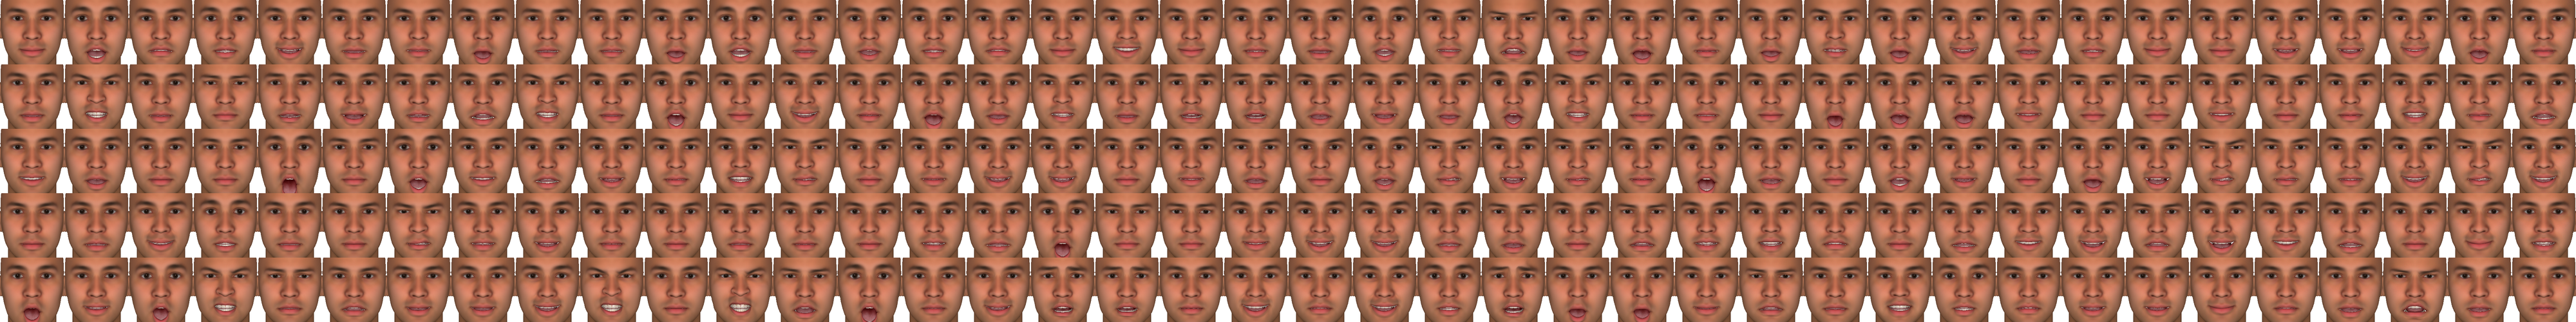

In [4]:
more_faces_path = os.path.join(os.path.abspath('..'), "CognitionData", "more_faces")

# initializing temp arrays
faceArray1 = np.zeros(shape=(100,1,3), dtype='uint8')
faceArray2 = np.zeros(shape=(100,1,3), dtype='uint8')
faceArray3 = np.zeros(shape=(100,1,3), dtype='uint8')
faceArray4 = np.zeros(shape=(100,1,3), dtype='uint8')
faceArray5 = np.zeros(shape=(100,1,3), dtype='uint8')

count = 0
for faceFilename in os.listdir(os.path.join(more_faces_path, 'img')):
    newFaceArray = np.array(Image.open(os.path.join(more_faces_path, 'img', faceFilename)))
    if count < 40:
        faceArray1 = np.concatenate((faceArray1, newFaceArray), axis=1)
    elif count < 80:
        faceArray2 = np.concatenate((faceArray2, newFaceArray), axis=1)
    elif count < 120:
        faceArray3 = np.concatenate((faceArray3, newFaceArray), axis=1)
    elif count < 160:
        faceArray4 = np.concatenate((faceArray4, newFaceArray), axis=1)
    elif count < 200:
        faceArray5 = np.concatenate((faceArray5, newFaceArray), axis=1)
    count += 1

# concatenating the arrays and removing the first temp column
faceArray = np.concatenate((faceArray1, faceArray2, faceArray3, faceArray4, faceArray5), axis=0)
faceArray = faceArray[:,1:,:]
Image.fromarray(faceArray)

In [5]:
data_transform = transforms.Compose([
        transforms.ToTensor()
    ])
more_faces_dataset = datasets.ImageFolder(root=more_faces_path, transform=data_transform)
more_faces_loader = torch.utils.data.DataLoader(more_faces_dataset,
                                             batch_size=BATCH_SIZE, shuffle=True,
                                             num_workers=4)

data_loaders = {"supervised": face_emotion_loader , "unsupervised": more_faces_loader }

### Model

In [6]:
class SSVAE(nn.Module):
    """
    This class encapsulates the parameters (neural networks), models & guides needed to train a
    semi-supervised variational auto-encoder.
    Modified from https://github.com/uber/pyro/blob/dev/examples/vae/ss_vae_M2.py

    :param output_size: size of the tensor representing the ratings 
                        in our case, emotion ratings is an 8 dimensional vector in [0,1]
                        global constant: helperCode.EMOTION_VAR_DIM (= 8)
    :param input_size: size of the tensor representing the face image 
                       in our case, 100*100*3, width*height*color = 30,000
    :param z_dim: size of the tensor representing the latent random variable z
    :param hidden_layers: a tuple (or list) of MultiLayer Perceptron (MLP) layers 
                          to be used in the neural networks
                          representing the parameters of the distributions in our model
    :param use_cuda: use GPUs for faster training
    :param aux_loss_multiplier: the multiplier to use with the auxiliary loss
    """
    def __init__(self, output_size=helperCode.EMOTION_VAR_DIM, input_size=IMG_SIZE, 
                 z_dim=DEFAULT_Z_DIM, hidden_layers=DEFAULT_HIDDEN_DIMS,
                 config_enum=None, use_cuda=False, aux_loss_multiplier=None):
        super(SSVAE, self).__init__()
        self.output_size = output_size
        self.input_size = input_size
        self.z_dim = z_dim
        self.hidden_layers = hidden_layers
        self.allow_broadcast = config_enum == 'parallel'
        self.use_cuda = use_cuda
        self.aux_loss_multiplier = aux_loss_multiplier
        
        # define the neural networks used later in the model and the guide.
        # these networks are MLPs (multi-layered perceptrons or simple feed-forward networks)
        # where the provided activation parameter is used on every linear layer except
        # for the output layer where we use the provided output_activation parameter
        
        # self.encoder_y = nn.Sequential(
        #       nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False)
        # )

        
        # a split in the final layer's size is used for multiple outputs
        # and potentially applying separate activation functions on them
        # e.g. in this network the final output is of size [z_dim, z_dim]
        # to produce a mean and scale parameter for a Normal distribution, 
        # and we can apply different activations [None, Exp] on them

        # encoder_y goes from image to ratings
        self.encoder_y = MLP([self.input_size] + self.hidden_layers + [[self.output_size, self.output_size]],
                             activation=nn.Tanh,
                             output_activation=[None, Exp],
                             allow_broadcast=self.allow_broadcast,
                             use_cuda=self.use_cuda)

        # encoder_z goes from [image, ratings] to z
        self.encoder_z = MLP([self.input_size + self.output_size] +
                             self.hidden_layers + [[z_dim, z_dim]],
                             activation=nn.ReLU,
                             output_activation=[None, Exp],
                             allow_broadcast=self.allow_broadcast,
                             use_cuda=self.use_cuda)

        # decoder goes from [z, emotion ratings] to the face image.
        self.decoder = MLP([z_dim + self.output_size] +
                           self.hidden_layers[::-1] + [self.input_size],
                           activation=nn.ReLU,
                           output_activation=nn.Sigmoid,
                           allow_broadcast=self.allow_broadcast,
                           use_cuda=self.use_cuda)
        
        # using GPUs for faster training of the networks
        if self.use_cuda:
            self.cuda()
            
    def model(self, xs, ys=None, beta=1.0):
        """
        The model corresponds to the following generative process:
        p(z)     = normal(0,I)              # Prior on the latent variable z
        p(y)     = normal(.5, .05)          # Emotion Rating corresponding to Face Image (semi-supervised)
        p(x|y,z) = bernoulli(decoder(y,z))  # Producing an image
                                              decoder is a neural network

        :param xs: a batch of scaled vectors of pixels from a face image
        :param ys: (optional) a batch of emotion ratings.
                   if ys is not provided, will treat as unsupervised, sample from prior.
        :param beta: scale parameter that weights the KL divergence in the ELBO
                     also sometimes called annealing.
        :return: None
        """
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("ssvae", self)

        batch_size = xs.size(0)
        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.iarange("data"):

            # sample the latent z from the (constant) prior, z ~ Normal(0,I)
            z_prior_mean  = torch.zeros(size=[batch_size, self.z_dim])
            z_prior_scale = torch.exp(torch.zeros(size=[batch_size, self.z_dim]))
            with poutine.scale(scale=beta):
                zs = pyro.sample("z", dist.Normal(z_prior_mean, z_prior_scale).independent(1))

            # if the label y (emotion rating) is not provided, sample from the
            # constant prior, otherwise, observe the value (i.e. score it against the constant prior)
            ys_prior_mean  = torch.ones(size=[batch_size, self.output_size]) *0.5 #/ (1.0 * self.output_size)
            ys_prior_scale = torch.ones(size=[batch_size, self.output_size]) *0.05
            if ys is None:
                ys = pyro.sample("y", dist.Normal(ys_prior_mean, ys_prior_scale).independent(1))
            else:
                ys = pyro.sample("y", dist.Normal(ys_prior_mean, ys_prior_scale).independent(1), obs=ys)
                
            # Finally, we can condition on observing the face image (x),
            #    using the latent z and emotion rating y in the 
            #    parametrized distribution p(x|y,z) = bernoulli(decoder(y,z))
            #    where decoder is a neural network
            
            x_means = self.decoder.forward([zs, ys])
            pyro.sample("x", dist.Bernoulli(x_means).independent(1), obs=xs)
            
            # return the x_means so we can visualize it later
            return x_means

    def guide(self, xs, ys=None, beta=1.0):
        """
        The guide corresponds to the following:
        q(y|x)   = normal(encoder_y(x))   # infer emotion rating from a face image
        q(z|x,y) = normal(encoder_z(x,y)) # infer z from a face image and the emotion rating

        :param xs: a batch of scaled vectors of pixels from a face image
        :param ys: (optional) a batch of emotion ratings.
                   if ys is not provided, will treat as unsupervised
        :param beta: not used here, but left to match the call signature of self.model()
        :return: None
        """
        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.iarange("data"):

            # if the emotion rating is not provided, 
            #    sample with the variational distribution
            #    q(y|x) = Normal(encoder_y(x))
            if ys is None:
                ys_mean, ys_scale = self.encoder_y.forward(xs)
                #scale_ys = xs.new_ones([batch_size, self.output_size])*0.05
                ys = pyro.sample("y", dist.Normal(ys_mean, ys_scale).independent(1))
                
            # Sample (and score) the latent z with the variational
            #   distribution q(z|x,y) = normal(loc(x,y),scale(x,y))
            #   where loc(.), scale(.) are given by encoder_z()
                        
            z_mean, z_scale = self.encoder_z.forward([xs, ys])
            with poutine.scale(scale=beta): 
                pyro.sample("z", dist.Normal(z_mean, z_scale).independent(1))

    def model_rating(self, xs, ys=None, beta=None):
        """
        this model is used to add an auxiliary (supervised) loss as described in
        Kingma et al. (2014), "Semi-Supervised Learning with Deep Generative Models".
        
        This is to ensure that the model learns from the supervised examples.
        q(y|x) = normal(encoder_y(x))
        
        :param xs:   face image
        :param ys:   emotion rating
        :param beta: not used here, but left to match the call signature of self.model()
        """
        # register all pytorch (sub)modules with pyro
        pyro.module("ssvae", self)

        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.iarange("data"):
            # this is the extra term to yield an auxiliary loss that we do gradient descent on
            if ys is not None:
                ys_mean, ys_scale = self.encoder_y.forward(xs)
                with pyro.poutine.scale(scale=self.aux_loss_multiplier):
                    pyro.sample("y_aux", dist.Normal(ys_mean, ys_scale).independent(1), obs=ys)

    def guide_rating(self, xs, ys=None, beta=None):
        """
        dummy guide function to accompany model_rating() in inference
        This guide function is empty, because model_rating() has no latent random variables
        (i.e., model_rating() has no pyro.sample() calls that are not conditioned on observations)
        """
        pass
    
    # define a helper function to assign ratings to faces
    def rate(self, xs):
        """
        assign emotion ratings (ys) to a face image (or a batch of images)

        :param xs: a batch of scaled vectors of pixels from a face image
        :return:   a batch of the corresponding emotion ratings (ys)
        """
        # use the trained model q(y|x) = normal(encoder_y(x))
        # compute the emotion ratings for the image(s)
        ys_mean, ys_scale = self.encoder_y.forward(xs)
        return ys_mean
    
    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x. This function assumes that x is a single image, 
        # but as the encoders and decoders take in batches, we have to resize x:
        xs = x.view(1, IMG_SIZE)
        ys_mean, ys_scale = self.encoder_y.forward(xs)
        ys = dist.Normal(ys_mean, ys_scale).sample()
        z_mean, z_scale = self.encoder_z.forward([xs, ys])
        # sample in latent space
        z = dist.Normal(z_mean, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder([z, ys])
        return loc_img

#### Training

Next we define the parameters of our training session, and set up the model and inference algorithm. This part is identical to the linear regression and VAE example.

The key difference is that we have 2 losses. 

- The unsupervised loss from the vanilla VAE, which is captured by ```loss_basic = SVI(ssvae.model, ssvae.guide, optimizer, loss=Trace_ELBO())``` 
- and the supervised loss, or auxillary loss, captured by ```loss_aux = SVI(ssvae.model_rating, ssvae.guide_rating, optimizer, loss=Trace_ELBO())```

At each loop in the training, we take one "basic" step and one "auxillary" step, to train the model with both losses together.

Since the training takes a while, `num_epochs` below is set to 1 just to demonstrate training (and it still might take a while!). Ideally you'll want to train for much longer.

In [ ]:
class Args:
    learning_rate = 5e-6#5e-4
    num_epochs = 1 #1000
    hidden_layers = DEFAULT_HIDDEN_DIMS
    z_dim = DEFAULT_Z_DIM
    seed = 1
    beta_1 = 0.900
    aux_loss = True 
    aux_loss_multiplier = 10 #50.0
    cuda = False
    # enum_discrete = None #"parallel"#"sequential" #"parallel"
    #visdom_flag = True
    #visualize = True
    #logfile = "./tmp.log"
    
args = Args()


pyro.clear_param_store()

unsup_num = len(more_faces_dataset)
sup_num = len(face_emotion_dataset)


if args.seed is not None:
    set_seed(args.seed, args.cuda)

# batch_size: number of images (and labels) to be considered in a batch
ssvae = SSVAE(output_size=helperCode.EMOTION_VAR_DIM, input_size=IMG_SIZE, 
              z_dim=args.z_dim,
              hidden_layers=args.hidden_layers,
              use_cuda=args.cuda,
              #config_enum=args.enum_discrete,
              aux_loss_multiplier=args.aux_loss_multiplier)

# setup the optimizer
adam_params = {"lr": args.learning_rate, "betas": (args.beta_1, 0.999)}
optimizer = Adam(adam_params)

# set up the loss(es) for inference. 

## wrapping the guide in config_enumerate builds the loss as a sum
## by enumerating each class label for the sampled discrete categorical distribution in the model
##guide = config_enumerate(ssvae.guide, args.enum_discrete)
##loss_basic = SVI(ssvae.model, guide, optimizer, loss=TraceEnum_ELBO(max_iarange_nesting=2))

loss_basic = SVI(ssvae.model, ssvae.guide, optimizer, loss=Trace_ELBO())

# build a list of all losses considered
losses = [loss_basic]

# aux_loss: whether to use the auxiliary loss from (Kingma et al, 2014 NIPS paper)
if args.aux_loss:
    loss_aux = SVI(ssvae.model_rating, ssvae.guide_rating, optimizer, loss=Trace_ELBO())
    losses.append(loss_aux)

#### Setting up Inference

This next chunk defines some helper functions to help run the inference

In [7]:
def getBeta(epoch, gamma=1e-2, c=800):
    # this is a helper function to compute an annealing parameter beta for a given epoch.
    # beta starts off near 0 and gradually increases, reaching 1 at epoch=c
    return float(expit(gamma*(epoch - c)))

def run_inference_for_epoch(data_loaders, losses, epoch, gamma=1e-2, c=800, cuda=False):
    """
    runs the inference algorithm for an epoch
    returns the values of all losses separately on supervised and unsupervised parts
    """
    num_losses = len(losses)

    # compute number of batches for an epoch
    # don't use all the sup_batches
    sup_batches = 20
    #sup_batches = len(data_loaders["supervised"])
    unsup_batches = len(data_loaders["unsupervised"])
    batches_per_epoch = sup_batches + unsup_batches

    # initialize variables to store loss values
    epoch_losses_sup = [0.] * num_losses
    epoch_losses_unsup = [0.] * num_losses

    # setup the iterators for training data loaders
    sup_iter = iter(data_loaders["supervised"])
    unsup_iter = iter(data_loaders["unsupervised"])

    # random order
    is_sups = [1]*sup_batches + [0]*unsup_batches
    is_sups = np.random.permutation(is_sups)
    
    # annealing factor
    beta = getBeta(epoch, gamma, c)
    
    for i in range(batches_per_epoch):
        #if i%10 == 0:
        #    print("Epoch", epoch, ": on batch", i, "out of", batches_per_epoch)
        # whether this batch is supervised or not
        is_supervised = is_sups[i]
        
        # extract the corresponding batch
        if is_supervised:
            xs, ys = next(sup_iter)
        else:
            xs, ys = next(unsup_iter)

        if cuda:
            ys = ys.cuda()
            xs = xs.cuda()
        
        batchsize = xs.size(0)
        xs = xs.view(batchsize, -1)
        
        # run the inference for each loss with supervised or un-supervised
        # data as arguments
        for loss_id in range(num_losses):
            if is_supervised:
                new_loss = losses[loss_id].step(xs, ys, beta=beta)
                epoch_losses_sup[loss_id] += new_loss
            else:
                new_loss = losses[loss_id].step(xs, beta=beta)
                epoch_losses_unsup[loss_id] += new_loss

    # return the values of all losses
    return epoch_losses_sup, epoch_losses_unsup

def get_prediction_error(data_loader, rating_fn):
    """
    compute the prediction error over the supervised training set or the testing set
    """
    predictions, actuals = [], []

    # use the appropriate data loader
    for (xs, ys) in data_loader:
        # use classification function to compute all predictions for each batch
        batchsize = xs.size(0)
        xs = xs.view(batchsize, -1)
        ys = ys.view(batchsize, -1)
        predictions.append(rating_fn(xs))
        actuals.append(ys)
        
    #abs(predictions[i] - actuals[i]) for i in range(len(predictions))

    predErrors = [abs(pred_i - act_i) for pred_i, act_i in zip(predictions, actuals)]
    meanPredError = sum([torch.sum(pe) for pe in predErrors]) / (len(predictions) * BATCH_SIZE * helperCode.EMOTION_VAR_DIM)

    return meanPredError, predictions, actuals

#### Training loop

This next chunk of code runs the training over `num_epochs` epochs.

In [8]:
try:
    # run inference for a certain number of epochs
    for i in range(0, args.num_epochs):

        # get the losses for an epoch
        epoch_losses_sup, epoch_losses_unsup = \
            run_inference_for_epoch(data_loaders, losses, epoch=i, cuda=args.cuda)

        # compute average epoch losses i.e. losses per example
        avg_epoch_losses_sup = map(lambda v: v / sup_num, epoch_losses_sup)
        avg_epoch_losses_unsup = map(lambda v: v / unsup_num, epoch_losses_unsup)

        # store the loss and validation/testing accuracies in the logfile
        #str_loss_sup = " ".join(map(str, avg_epoch_losses_sup))
        #str_loss_unsup = " ".join(map(str, avg_epoch_losses_unsup))
        str_loss_sup = "Supervised Recon Loss: " + str(avg_epoch_losses_sup[0]) + \
        "\n     Auxillary Loss: " + str(avg_epoch_losses_sup[1])
        str_loss_unsup = "\n     Unsupervised Recon Loss: " + str(avg_epoch_losses_unsup[0])

        str_print = "Epoch {} : Avg {}".format(i, "{} {}".format(str_loss_sup, str_loss_unsup))
        
        predErr, _, _ = get_prediction_error(data_loaders["supervised"], ssvae.rate)
        str_print += "\n     Train set prediction error: {}".format(predErr)
        print(str_print)
finally:
    print("Done")


Epoch 0 : Avg Supervised Recon Loss: 8163.90230541
     Auxillary Loss: 31.7895033006 
     Unsupervised Recon Loss: 22508.7403536
     Train set prediction error: 0.285677194595
Epoch 1 : Avg Supervised Recon Loss: 2661.37835036
     Auxillary Loss: 29.9221181782 
     Unsupervised Recon Loss: 22396.9619638
     Train set prediction error: 0.278913229704
Epoch 2 : Avg Supervised Recon Loss: -8951.36141747
     Auxillary Loss: 28.2867606485 
     Unsupervised Recon Loss: 22178.0245684
     Train set prediction error: 0.274098783731
Epoch 3 : Avg Supervised Recon Loss: 5523.26462555
     Auxillary Loss: 26.3916757511 
     Unsupervised Recon Loss: 21965.895299
     Train set prediction error: 0.268630832434
Epoch 4 : Avg Supervised Recon Loss: 4619.33860946
     Auxillary Loss: 25.5048677342 
     Unsupervised Recon Loss: 21904.0524651
     Train set prediction error: 0.266570538282
Epoch 5 : Avg Supervised Recon Loss: 1084.61841462
     Auxillary Loss: 24.0090941581 
     Unsupervised 

Epoch 46 : Avg Supervised Recon Loss: -8222985.94146
     Auxillary Loss: 10.0057636116 
     Unsupervised Recon Loss: 20953.4550589
     Train set prediction error: 0.282553434372
Epoch 47 : Avg Supervised Recon Loss: -9185949.6978
     Auxillary Loss: 10.3560039906 
     Unsupervised Recon Loss: 20957.840393
     Train set prediction error: 0.279776275158
Epoch 48 : Avg Supervised Recon Loss: -9563152.32707
     Auxillary Loss: 10.4124676458 
     Unsupervised Recon Loss: 20962.3629898
     Train set prediction error: 0.282260119915
Epoch 49 : Avg Supervised Recon Loss: -9601783.62515
     Auxillary Loss: 10.9902826577 
     Unsupervised Recon Loss: 20942.1208906
     Train set prediction error: 0.28081998229
Epoch 50 : Avg Supervised Recon Loss: -9676427.00463
     Auxillary Loss: 10.4492230008 
     Unsupervised Recon Loss: 20946.9194158
     Train set prediction error: 0.280629903078
Epoch 51 : Avg Supervised Recon Loss: -10392531.8672
     Auxillary Loss: 11.2440536038 
     Unsu

Epoch 92 : Avg Supervised Recon Loss: -13946620.5299
     Auxillary Loss: 10.0253331589 
     Unsupervised Recon Loss: 21101.1092739
     Train set prediction error: 0.267073154449
Epoch 93 : Avg Supervised Recon Loss: -14507122.7036
     Auxillary Loss: 9.48583743763 
     Unsupervised Recon Loss: 21132.6045524
     Train set prediction error: 0.26496514678
Epoch 94 : Avg Supervised Recon Loss: -15032945.264
     Auxillary Loss: 10.1830576071 
     Unsupervised Recon Loss: 21133.2451467
     Train set prediction error: 0.265180230141
Epoch 95 : Avg Supervised Recon Loss: -14699965.9116
     Auxillary Loss: 10.3212193653 
     Unsupervised Recon Loss: 21146.3914439
     Train set prediction error: 0.263923257589
Epoch 96 : Avg Supervised Recon Loss: -14978248.3643
     Auxillary Loss: 8.94858578094 
     Unsupervised Recon Loss: 21141.9381615
     Train set prediction error: 0.264232039452
Epoch 97 : Avg Supervised Recon Loss: -15389169.2914
     Auxillary Loss: 9.59311983808 
     Uns

Epoch 138 : Avg Supervised Recon Loss: -24134199.0759
     Auxillary Loss: 12.7385494919 
     Unsupervised Recon Loss: 22025.7528661
     Train set prediction error: 0.253376871347
Epoch 139 : Avg Supervised Recon Loss: -24200545.7712
     Auxillary Loss: 11.8950314215 
     Unsupervised Recon Loss: 22083.3164631
     Train set prediction error: 0.254708766937
Epoch 140 : Avg Supervised Recon Loss: -24228724.0409
     Auxillary Loss: 13.5824396081 
     Unsupervised Recon Loss: 22124.4846219
     Train set prediction error: 0.255954235792
Epoch 141 : Avg Supervised Recon Loss: -24302963.2205
     Auxillary Loss: 14.1223039063 
     Unsupervised Recon Loss: 22117.4912412
     Train set prediction error: 0.256031662226
Epoch 142 : Avg Supervised Recon Loss: -24288870.4054
     Auxillary Loss: 14.0750797788 
     Unsupervised Recon Loss: 22152.0401595
     Train set prediction error: 0.255336374044
Epoch 143 : Avg Supervised Recon Loss: -24318856.5482
     Auxillary Loss: 13.8248997411 


Epoch 184 : Avg Supervised Recon Loss: -24489164.849
     Auxillary Loss: 16.3399016572 
     Unsupervised Recon Loss: 22250.2607183
     Train set prediction error: 0.263785213232
Epoch 185 : Avg Supervised Recon Loss: -24498711.6137
     Auxillary Loss: 14.4805101753 
     Unsupervised Recon Loss: 22342.3307105
     Train set prediction error: 0.261628240347
Epoch 186 : Avg Supervised Recon Loss: -24499754.2655
     Auxillary Loss: 16.8522741892 
     Unsupervised Recon Loss: 22254.0560163
     Train set prediction error: 0.263541966677
Epoch 187 : Avg Supervised Recon Loss: -24498100.953
     Auxillary Loss: 14.3439382385 
     Unsupervised Recon Loss: 22249.347178
     Train set prediction error: 0.262950897217
Epoch 188 : Avg Supervised Recon Loss: -24492658.5072
     Auxillary Loss: 14.0833159558 
     Unsupervised Recon Loss: 22358.767788
     Train set prediction error: 0.261984467506
Epoch 189 : Avg Supervised Recon Loss: -24491513.9884
     Auxillary Loss: 15.4313470387 
    

Epoch 230 : Avg Supervised Recon Loss: -24490391.6202
     Auxillary Loss: 14.2975583772 
     Unsupervised Recon Loss: 22139.807141
     Train set prediction error: 0.260412186384
Epoch 231 : Avg Supervised Recon Loss: -24489544.8819
     Auxillary Loss: 13.2963802022 
     Unsupervised Recon Loss: 22189.7900343
     Train set prediction error: 0.259637087584
Epoch 232 : Avg Supervised Recon Loss: -24497091.4275
     Auxillary Loss: 13.5342838122 
     Unsupervised Recon Loss: 22386.2411206
     Train set prediction error: 0.25888171792
Epoch 233 : Avg Supervised Recon Loss: -24498066.738
     Auxillary Loss: 14.3744429038 
     Unsupervised Recon Loss: 22251.0492843
     Train set prediction error: 0.260585695505
Epoch 234 : Avg Supervised Recon Loss: -24491325.6322
     Auxillary Loss: 14.6937812073 
     Unsupervised Recon Loss: 22163.7167098
     Train set prediction error: 0.260078310966
Epoch 235 : Avg Supervised Recon Loss: -24500573.842
     Auxillary Loss: 14.5006587546 
    

Epoch 276 : Avg Supervised Recon Loss: -24493487.4351
     Auxillary Loss: 11.1420687602 
     Unsupervised Recon Loss: 22115.101071
     Train set prediction error: 0.256335586309
Epoch 277 : Avg Supervised Recon Loss: -24500443.2584
     Auxillary Loss: 11.7083869162 
     Unsupervised Recon Loss: 22077.648129
     Train set prediction error: 0.255170732737
Epoch 278 : Avg Supervised Recon Loss: -24494623.016
     Auxillary Loss: 10.9571815721 
     Unsupervised Recon Loss: 22007.3829561
     Train set prediction error: 0.25601837039
Epoch 279 : Avg Supervised Recon Loss: -24496123.8941
     Auxillary Loss: 12.0412679665 
     Unsupervised Recon Loss: 22082.8699503
     Train set prediction error: 0.254611521959
Epoch 280 : Avg Supervised Recon Loss: -24491860.0479
     Auxillary Loss: 10.6545387098 
     Unsupervised Recon Loss: 22030.3754084
     Train set prediction error: 0.253242194653
Epoch 281 : Avg Supervised Recon Loss: -24489717.4863
     Auxillary Loss: 10.1615175505 
    

Epoch 322 : Avg Supervised Recon Loss: -24493571.3061
     Auxillary Loss: 8.89829038602 
     Unsupervised Recon Loss: 21559.9476832
     Train set prediction error: 0.257176011801
Epoch 323 : Avg Supervised Recon Loss: -24497567.9862
     Auxillary Loss: 8.8758423413 
     Unsupervised Recon Loss: 21561.4601702
     Train set prediction error: 0.25551083684
Epoch 324 : Avg Supervised Recon Loss: -24481532.9009
     Auxillary Loss: 10.0953086021 
     Unsupervised Recon Loss: 21532.7186109
     Train set prediction error: 0.257581025362
Epoch 325 : Avg Supervised Recon Loss: -24503778.3003
     Auxillary Loss: 9.11564443741 
     Unsupervised Recon Loss: 21554.7083681
     Train set prediction error: 0.256352156401
Epoch 326 : Avg Supervised Recon Loss: -24507671.8194
     Auxillary Loss: 9.39846863916 
     Unsupervised Recon Loss: 21444.2772594
     Train set prediction error: 0.257583349943
Epoch 327 : Avg Supervised Recon Loss: -24504045.5027
     Auxillary Loss: 8.73423963589 
  

Epoch 368 : Avg Supervised Recon Loss: -24500296.2466
     Auxillary Loss: 9.46322788234 
     Unsupervised Recon Loss: 21300.9955666
     Train set prediction error: 0.265000760555
Epoch 369 : Avg Supervised Recon Loss: -24495119.8056
     Auxillary Loss: 9.25010562852 
     Unsupervised Recon Loss: 21303.1071553
     Train set prediction error: 0.264082551003
Epoch 370 : Avg Supervised Recon Loss: -24495662.0087
     Auxillary Loss: 8.29964179341 
     Unsupervised Recon Loss: 21331.4194023
     Train set prediction error: 0.264305353165
Epoch 371 : Avg Supervised Recon Loss: -24510234.688
     Auxillary Loss: 9.80002851649 
     Unsupervised Recon Loss: 21338.4083286
     Train set prediction error: 0.265869408846
Epoch 372 : Avg Supervised Recon Loss: -24507729.9755
     Auxillary Loss: 10.0002059836 
     Unsupervised Recon Loss: 21299.4652476
     Train set prediction error: 0.265129625797
Epoch 373 : Avg Supervised Recon Loss: -24499337.056
     Auxillary Loss: 8.5960500068 
   

Epoch 414 : Avg Supervised Recon Loss: -24501223.3325
     Auxillary Loss: 10.4879770768 
     Unsupervised Recon Loss: 21101.0672429
     Train set prediction error: 0.272163271904
Epoch 415 : Avg Supervised Recon Loss: -24498191.1066
     Auxillary Loss: 10.5953118503 
     Unsupervised Recon Loss: 21089.8553718
     Train set prediction error: 0.273004800081
Epoch 416 : Avg Supervised Recon Loss: -24492421.9605
     Auxillary Loss: 10.0906666218 
     Unsupervised Recon Loss: 21108.9729314
     Train set prediction error: 0.27211561799
Epoch 417 : Avg Supervised Recon Loss: -24505211.8967
     Auxillary Loss: 10.825046013 
     Unsupervised Recon Loss: 21058.7348268
     Train set prediction error: 0.274294644594
Epoch 418 : Avg Supervised Recon Loss: -24502405.8594
     Auxillary Loss: 10.6873701299 
     Unsupervised Recon Loss: 21059.8186476
     Train set prediction error: 0.272587537766
Epoch 419 : Avg Supervised Recon Loss: -24505086.6258
     Auxillary Loss: 10.1211508351 
  

Epoch 460 : Avg Supervised Recon Loss: -24491844.5379
     Auxillary Loss: 10.7075747917 
     Unsupervised Recon Loss: 20878.5251867
     Train set prediction error: 0.273741215467
Epoch 461 : Avg Supervised Recon Loss: -24493230.8439
     Auxillary Loss: 11.4026944415 
     Unsupervised Recon Loss: 20880.3657684
     Train set prediction error: 0.276544123888
Epoch 462 : Avg Supervised Recon Loss: -24499769.7082
     Auxillary Loss: 11.2570587639 
     Unsupervised Recon Loss: 20861.4754297
     Train set prediction error: 0.275830984116
Epoch 463 : Avg Supervised Recon Loss: -24499851.708
     Auxillary Loss: 10.3724175552 
     Unsupervised Recon Loss: 20876.2947343
     Train set prediction error: 0.275061249733
Epoch 464 : Avg Supervised Recon Loss: -24500054.292
     Auxillary Loss: 10.3309414396 
     Unsupervised Recon Loss: 20864.0637155
     Train set prediction error: 0.275835633278
Epoch 465 : Avg Supervised Recon Loss: -24486283.857
     Auxillary Loss: 10.7553041235 
   

Epoch 506 : Avg Supervised Recon Loss: -24501580.5891
     Auxillary Loss: 9.87934847417 
     Unsupervised Recon Loss: 20644.8468422
     Train set prediction error: 0.274482280016
Epoch 507 : Avg Supervised Recon Loss: -24490704.5452
     Auxillary Loss: 10.6587059833 
     Unsupervised Recon Loss: 20638.5901794
     Train set prediction error: 0.273795992136
Epoch 508 : Avg Supervised Recon Loss: -24497486.0228
     Auxillary Loss: 9.75791450932 
     Unsupervised Recon Loss: 20634.8731263
     Train set prediction error: 0.272329777479
Epoch 509 : Avg Supervised Recon Loss: -24495254.418
     Auxillary Loss: 10.9984159733 
     Unsupervised Recon Loss: 20642.2192059
     Train set prediction error: 0.274596422911
Epoch 510 : Avg Supervised Recon Loss: -24505914.2144
     Auxillary Loss: 10.4061623973 
     Unsupervised Recon Loss: 20611.9595442
     Train set prediction error: 0.274644523859
Epoch 511 : Avg Supervised Recon Loss: -24493712.3843
     Auxillary Loss: 10.6918338169 
 

Epoch 552 : Avg Supervised Recon Loss: -24491965.897
     Auxillary Loss: 11.3686402731 
     Unsupervised Recon Loss: 20283.2062204
     Train set prediction error: 0.275200754404
Epoch 553 : Avg Supervised Recon Loss: -24508422.8396
     Auxillary Loss: 10.0293860216 
     Unsupervised Recon Loss: 20295.4768983
     Train set prediction error: 0.274472355843
Epoch 554 : Avg Supervised Recon Loss: -24506257.9295
     Auxillary Loss: 9.96435703273 
     Unsupervised Recon Loss: 20303.7661
     Train set prediction error: 0.275357246399
Epoch 555 : Avg Supervised Recon Loss: -24489873.8038
     Auxillary Loss: 10.8385894815 
     Unsupervised Recon Loss: 20271.903467
     Train set prediction error: 0.275051772594
Epoch 556 : Avg Supervised Recon Loss: -24495496.9702
     Auxillary Loss: 10.0837169752 
     Unsupervised Recon Loss: 20274.5217847
     Train set prediction error: 0.274880439043
Epoch 557 : Avg Supervised Recon Loss: -24499119.6004
     Auxillary Loss: 10.9203709566 
     

Epoch 598 : Avg Supervised Recon Loss: -24491502.2346
     Auxillary Loss: 11.5498607099 
     Unsupervised Recon Loss: 20167.0814044
     Train set prediction error: 0.277516812086
Epoch 599 : Avg Supervised Recon Loss: -24496423.095
     Auxillary Loss: 11.6832195187 
     Unsupervised Recon Loss: 20091.9314625
     Train set prediction error: 0.275437921286
Epoch 600 : Avg Supervised Recon Loss: -24482631.8228
     Auxillary Loss: 11.0857770521 
     Unsupervised Recon Loss: 20102.846294
     Train set prediction error: 0.275113284588
Epoch 601 : Avg Supervised Recon Loss: -24499098.9975
     Auxillary Loss: 11.2223322063 
     Unsupervised Recon Loss: 20131.9399877
     Train set prediction error: 0.276085406542
Epoch 602 : Avg Supervised Recon Loss: -24496878.146
     Auxillary Loss: 10.3776284818 
     Unsupervised Recon Loss: 20097.5868609
     Train set prediction error: 0.275474995375
Epoch 603 : Avg Supervised Recon Loss: -24488594.9316
     Auxillary Loss: 12.2055181235 
   

Epoch 644 : Avg Supervised Recon Loss: -24488475.7746
     Auxillary Loss: 10.9734971877 
     Unsupervised Recon Loss: 19977.2145847
     Train set prediction error: 0.280362576246
Epoch 645 : Avg Supervised Recon Loss: -24481487.4798
     Auxillary Loss: 11.7205419553 
     Unsupervised Recon Loss: 19958.8111156
     Train set prediction error: 0.278127938509
Epoch 646 : Avg Supervised Recon Loss: -24492061.1584
     Auxillary Loss: 11.6107033969 
     Unsupervised Recon Loss: 19995.9500499
     Train set prediction error: 0.2786655128
Epoch 647 : Avg Supervised Recon Loss: -24496619.6704
     Auxillary Loss: 10.8817321938 
     Unsupervised Recon Loss: 19986.0873442
     Train set prediction error: 0.276147574186
Epoch 648 : Avg Supervised Recon Loss: -24498906.7861
     Auxillary Loss: 11.165199771 
     Unsupervised Recon Loss: 19949.3623274
     Train set prediction error: 0.276699304581
Epoch 649 : Avg Supervised Recon Loss: -24496125.3807
     Auxillary Loss: 9.79316863813 
   

Epoch 690 : Avg Supervised Recon Loss: -24504202.072
     Auxillary Loss: 11.9633045572 
     Unsupervised Recon Loss: 19880.0852671
     Train set prediction error: 0.281475365162
Epoch 691 : Avg Supervised Recon Loss: -24486188.7023
     Auxillary Loss: 10.981844407 
     Unsupervised Recon Loss: 19854.1714914
     Train set prediction error: 0.28145211935
Epoch 692 : Avg Supervised Recon Loss: -24494138.5593
     Auxillary Loss: 12.6670889936 
     Unsupervised Recon Loss: 19852.2777261
     Train set prediction error: 0.282355964184
Epoch 693 : Avg Supervised Recon Loss: -24488177.0636
     Auxillary Loss: 12.0643232749 
     Unsupervised Recon Loss: 19867.6718536
     Train set prediction error: 0.279196232557
Epoch 694 : Avg Supervised Recon Loss: -24498123.9969
     Auxillary Loss: 12.1696767719 
     Unsupervised Recon Loss: 19867.4602846
     Train set prediction error: 0.280742377043
Epoch 695 : Avg Supervised Recon Loss: -24490262.8078
     Auxillary Loss: 11.5324654097 
   

Epoch 736 : Avg Supervised Recon Loss: -24497006.0379
     Auxillary Loss: 11.0950605716 
     Unsupervised Recon Loss: 19727.7210045
     Train set prediction error: 0.283337563276
Epoch 737 : Avg Supervised Recon Loss: -24493804.4555
     Auxillary Loss: 12.7777177407 
     Unsupervised Recon Loss: 19730.2167325
     Train set prediction error: 0.284905999899
Epoch 738 : Avg Supervised Recon Loss: -24506675.3392
     Auxillary Loss: 11.9107801961 
     Unsupervised Recon Loss: 19745.1370149
     Train set prediction error: 0.282552480698
Epoch 739 : Avg Supervised Recon Loss: -24508056.8973
     Auxillary Loss: 11.6954760758 
     Unsupervised Recon Loss: 19714.7543737
     Train set prediction error: 0.283075690269
Epoch 740 : Avg Supervised Recon Loss: -24490197.581
     Auxillary Loss: 11.979139932 
     Unsupervised Recon Loss: 19717.9305751
     Train set prediction error: 0.285745501518
Epoch 741 : Avg Supervised Recon Loss: -24490224.3924
     Auxillary Loss: 13.0474002953 
  

Epoch 782 : Avg Supervised Recon Loss: -24497425.3426
     Auxillary Loss: 11.7236094732 
     Unsupervised Recon Loss: 19709.5144279
     Train set prediction error: 0.284628450871
Epoch 783 : Avg Supervised Recon Loss: -24490438.9229
     Auxillary Loss: 12.9163964731 
     Unsupervised Recon Loss: 19716.5711453
     Train set prediction error: 0.28501984477
Epoch 784 : Avg Supervised Recon Loss: -24496662.0683
     Auxillary Loss: 12.2668685612 
     Unsupervised Recon Loss: 19694.5358663
     Train set prediction error: 0.286624580622
Epoch 785 : Avg Supervised Recon Loss: -24493690.4407
     Auxillary Loss: 13.5979635913 
     Unsupervised Recon Loss: 19691.5741897
     Train set prediction error: 0.285649508238
Epoch 786 : Avg Supervised Recon Loss: -24495570.1197
     Auxillary Loss: 12.1363814125 
     Unsupervised Recon Loss: 19723.3770302
     Train set prediction error: 0.283207565546
Epoch 787 : Avg Supervised Recon Loss: -24495090.8415
     Auxillary Loss: 11.2124393979 
 

Epoch 828 : Avg Supervised Recon Loss: -24493295.8949
     Auxillary Loss: 13.4668597949 
     Unsupervised Recon Loss: 19674.1327487
     Train set prediction error: 0.283125162125
Epoch 829 : Avg Supervised Recon Loss: -24483556.6774
     Auxillary Loss: 11.863088881 
     Unsupervised Recon Loss: 19648.002984
     Train set prediction error: 0.280875712633
Epoch 830 : Avg Supervised Recon Loss: -24493897.8835
     Auxillary Loss: 11.0058578912 
     Unsupervised Recon Loss: 19707.0718889
     Train set prediction error: 0.28255161643
Epoch 831 : Avg Supervised Recon Loss: -24487486.7275
     Auxillary Loss: 11.400543253 
     Unsupervised Recon Loss: 19713.3583155
     Train set prediction error: 0.28038969636
Epoch 832 : Avg Supervised Recon Loss: -24491954.4593
     Auxillary Loss: 11.3872632542 
     Unsupervised Recon Loss: 19741.3692976
     Train set prediction error: 0.2822009027
Epoch 833 : Avg Supervised Recon Loss: -24484010.0783
     Auxillary Loss: 12.2229007114 
     Un

Epoch 874 : Avg Supervised Recon Loss: -24491656.8999
     Auxillary Loss: 13.3222574041 
     Unsupervised Recon Loss: 19657.5660334
     Train set prediction error: 0.285400003195
Epoch 875 : Avg Supervised Recon Loss: -24497343.2474
     Auxillary Loss: 11.9966638392 
     Unsupervised Recon Loss: 19700.8909072
     Train set prediction error: 0.283382713795
Epoch 876 : Avg Supervised Recon Loss: -24497627.7995
     Auxillary Loss: 12.2548715439 
     Unsupervised Recon Loss: 19677.8234266
     Train set prediction error: 0.283726543188
Epoch 877 : Avg Supervised Recon Loss: -24494585.0316
     Auxillary Loss: 13.6483474711 
     Unsupervised Recon Loss: 19686.197124
     Train set prediction error: 0.286264955997
Epoch 878 : Avg Supervised Recon Loss: -24498404.4547
     Auxillary Loss: 12.4148067118 
     Unsupervised Recon Loss: 19747.4821478
     Train set prediction error: 0.281276792288
Epoch 879 : Avg Supervised Recon Loss: -24490171.1484
     Auxillary Loss: 10.6280787464 
 

Epoch 920 : Avg Supervised Recon Loss: -24502341.5911
     Auxillary Loss: 11.977682066 
     Unsupervised Recon Loss: 19750.1033533
     Train set prediction error: 0.280093580484
Epoch 921 : Avg Supervised Recon Loss: -24493924.2756
     Auxillary Loss: 11.6672387342 
     Unsupervised Recon Loss: 19794.2956215
     Train set prediction error: 0.282110840082
Epoch 922 : Avg Supervised Recon Loss: -24489440.4561
     Auxillary Loss: 12.2667679054 
     Unsupervised Recon Loss: 19740.9099648
     Train set prediction error: 0.282303959131
Epoch 923 : Avg Supervised Recon Loss: -24491356.7735
     Auxillary Loss: 11.9286416413 
     Unsupervised Recon Loss: 19661.2865374
     Train set prediction error: 0.281656861305
Epoch 924 : Avg Supervised Recon Loss: -24498247.4569
     Auxillary Loss: 11.595647263 
     Unsupervised Recon Loss: 19728.9523538
     Train set prediction error: 0.28180205822
Epoch 925 : Avg Supervised Recon Loss: -24488347.7435
     Auxillary Loss: 11.4982433344 
   

Epoch 966 : Avg Supervised Recon Loss: -24489579.0536
     Auxillary Loss: 11.0837466908 
     Unsupervised Recon Loss: 19783.8697411
     Train set prediction error: 0.278449475765
Epoch 967 : Avg Supervised Recon Loss: -24496584.4725
     Auxillary Loss: 12.34885606 
     Unsupervised Recon Loss: 19670.6210754
     Train set prediction error: 0.281473755836
Epoch 968 : Avg Supervised Recon Loss: -24492049.1297
     Auxillary Loss: 12.587614082 
     Unsupervised Recon Loss: 19750.4765298
     Train set prediction error: 0.281365901232
Epoch 969 : Avg Supervised Recon Loss: -24500447.4615
     Auxillary Loss: 12.4240674333 
     Unsupervised Recon Loss: 19730.4678857
     Train set prediction error: 0.282847136259
Epoch 970 : Avg Supervised Recon Loss: -24494341.6054
     Auxillary Loss: 12.7510755742 
     Unsupervised Recon Loss: 19731.7208251
     Train set prediction error: 0.284203618765
Epoch 971 : Avg Supervised Recon Loss: -24494107.9912
     Auxillary Loss: 11.7841480471 
   

Because the model above takes a while to train, you can use the following two chunks to save or load a model. We assume that you'll skip this save step and load the model from `trained_models/`. It's a large file so you can download it from: https://www.dropbox.com/s/f1pckm5vc64fihm/ssvae_pretrained.save?dl=0 and put it into `trained_models/`

In [9]:
# save model
savemodel = False
if savemodel:
    pyro.get_param_store().save('trained_models/ssvae_pretrained.save')

In [10]:
loadmodel = True
if loadmodel:
    pyro.get_param_store().load('trained_models/ssvae_pretrained.save')
    pyro.module("ssvae", ssvae, update_module_params=True)

In [11]:
pyro.get_param_store().get_all_param_names()

['ssvae$$$encoder_y.sequential_mlp.3.bias',
 'ssvae$$$decoder.sequential_mlp.3.weight',
 'ssvae$$$encoder_y.sequential_mlp.1.bias',
 'ssvae$$$decoder.sequential_mlp.1.weight',
 'ssvae$$$decoder.sequential_mlp.3.bias',
 'ssvae$$$encoder_z.sequential_mlp.5.1.0.bias',
 'ssvae$$$encoder_y.sequential_mlp.1.weight',
 'ssvae$$$encoder_z.sequential_mlp.5.0.0.weight',
 'ssvae$$$encoder_y.sequential_mlp.5.0.0.bias',
 'ssvae$$$encoder_y.sequential_mlp.3.weight',
 'ssvae$$$encoder_z.sequential_mlp.5.0.0.bias',
 'ssvae$$$encoder_z.sequential_mlp.3.weight',
 'ssvae$$$encoder_z.sequential_mlp.1.weight',
 'ssvae$$$encoder_y.sequential_mlp.5.0.0.weight',
 'ssvae$$$encoder_z.sequential_mlp.5.1.0.weight',
 'ssvae$$$encoder_y.sequential_mlp.5.1.0.weight',
 'ssvae$$$decoder.sequential_mlp.5.bias',
 'ssvae$$$encoder_y.sequential_mlp.5.1.0.bias',
 'ssvae$$$decoder.sequential_mlp.1.bias',
 'ssvae$$$encoder_z.sequential_mlp.1.bias',
 'ssvae$$$encoder_z.sequential_mlp.3.bias',
 'ssvae$$$decoder.sequential_mlp.5

Reconstruct images

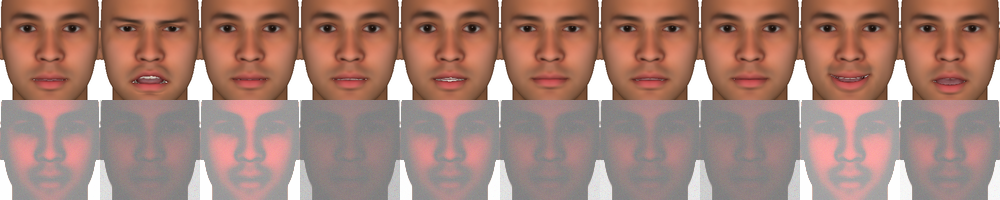

In [13]:
NUM_SAMPLES = 10
input_array = np.zeros(shape=(IMG_WIDTH, 1, 3), dtype="uint8")
reconstructed_array = np.zeros(shape=(IMG_WIDTH, 1, 3), dtype="uint8")

for i, (x, _) in enumerate(more_faces_loader):
    # pick NUM_SAMPLES random test images from the first mini-batch and
    # visualize how well we're reconstructing them
    if i == 0:
        reco_indices = np.random.randint(0, x.size(0), NUM_SAMPLES)
        for index in reco_indices:
            input_img = x[index, :]
            # storing the input image
            input_img_display = np.array(input_img*255., dtype='uint8')
            input_img_display = input_img_display.transpose((1, 2, 0))
            input_array = np.concatenate((input_array, input_img_display), axis=1)

            # generating the reconstructed image and adding to array
            reconstructed_img = ssvae.reconstruct_img(input_img)
            reconstructed_img = reconstructed_img.view(3, IMG_WIDTH, IMG_WIDTH).detach().numpy()
            reconstructed_img = np.array(reconstructed_img*255., dtype='uint8')
            reconstructed_img = reconstructed_img.transpose((1, 2, 0))
            reconstructed_array = np.concatenate((reconstructed_array, reconstructed_img), axis=1)

# remove first, blank column, and concatenate
input_array = input_array[:,1:,:]
reconstructed_array = reconstructed_array[:,1:,:]
display_array = np.concatenate((input_array, reconstructed_array), axis=0)
Image.fromarray(display_array)

### Extensions to a multimodal VAE

Another way this model can be extended is to fully let the latent $z$ "cause" both the emotion ratings and the facial expression. That's an example of a Multimodal VAE (Wu & Goodman, 2018).

There is a nice theoretical motivation for this model too. Throughout, we've assumed that the space of emotions is exactly what we measured (e.g., some value of happiness, some value of sadness), but maybe the latent space is more structured, but not along these discrete emotion categories -- perhaps along dimensions like "good" vs "bad", or . In emotion theory, this undifferentiated space is called affect, and often, this is a low-dimensional space (2 to 3 dimensions capture most of the variance in empirical data).

We could thus posit a latent *affect*, and actually we would still want a $z$ that captures non-emotional aspects of the face -- learning to disentangle latent variables is also an active area of research (Narayanaswamy et al, 2017).

And finally, we can add the "outcome to appraisal to affect" part back into this multimodal model.

<div style="width: 300px; margin: auto; ">![Graphical Model](images/graphicalModel_MVAE.png)
</div>

(Here are some example conditioned output from the model! Code coming soon).

<div style="width: 300px; margin: auto; ">![Example output](images/TAC_outputSamples.png)
</div>

-----

Written by: Desmond Ong (desmond.c.ong@gmail.com) and Harold Soh (hsoh@comp.nus.edu.sg)

References:

Pyro [VAE tutorial](http://pyro.ai/examples/vae.html), [SSVAE tutorial](http://pyro.ai/examples/ss-vae.html)

Hoffman, M. D., Blei, D. M., Wang, C., & Paisley, J. (2013). Stochastic
variational inference. *The Journal of Machine Learning Research*, 14(1),
1303-1347.

Kingma, D. P., Mohamed, S., Rezende, D. J., & Welling, M. (2014). Semi-supervised learning with deep generative models. In *Advances in Neural Information Processing Systems*, pp. 3581-3589. https://arxiv.org/abs/1406.5298

Kingma, D. P., & Welling, M. (2014). Auto-encoding variational bayes. Auto-Encoding Variational Bayes. In *The International Conference on Learning Representations*. https://arxiv.org/abs/1312.6114


Narayanaswamy, S., Paige, T. B., van de Meent, J. W., Desmaison, A., Goodman, N. D., Kohli, P., Wood, F. & Torr, P. (2017). Learning Disentangled Representations with Semi-Supervised Deep Generative Models. In *Advances in Neural Information Processing Systems*, pp. 5927-5937. https://arxiv.org/abs/1706.00400

Data from https://github.com/desmond-ong/affCog, from the following paper:

Ong, D. C., Zaki, J., & Goodman, N. D. (2015). Affective Cognition: Exploring lay theories of emotion. *Cognition*, 143, 141-162.